In [7]:
print("All ok!")

All ok!


In [8]:
# !pip3 install langgraph

In [9]:
from langgraph.graph import StateGraph
from typing import TypedDict

class State(TypedDict):
    input: str

workflow1 = StateGraph(State)

# state ={"input":"user query"}

In [10]:
def function1(state :State) -> State:
    variable = state["input"]
    return {"input": variable + "function1 has been executed."}

## state ={"input": userquery function1 has been executed." }


def function2(state :State) -> State:
    return {"input": state["input"] + " function2 has been executed."}

## state ={"input": userquery function1 has been executed. function2 has been executed." }

In [12]:
workflow1.add_node("function1", function1)
workflow1.add_node("function2", function2)

In [13]:
workflow1.add_edge("function1", "function2")

In [14]:
workflow1.set_entry_point("function1")
workflow1.set_finish_point("function2")

In [15]:
app = workflow1.compile()

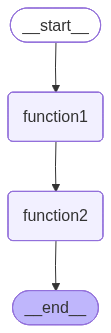

In [16]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [17]:
app.invoke({"input": "Please run the two functions"})

{'input': 'Please run the two functionsfunction1 has been executed. function2 has been executed.'}

In [21]:
for output in app.stream({"input": "Please run the two functions"}):
    for  key, value in output.items():

        print(f"{key}: \n {value}")

function1: 
 {'input': 'Please run the two functionsfunction1 has been executed.'}
function2: 
 {'input': 'Please run the two functionsfunction1 has been executed. function2 has been executed.'}


## Example 2:

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "your_api_key_here"

In [23]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model="gpt-4o-mini",   # fast + cheap
    temperature=0.7
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
response = model.invoke("What is the capital of France?")
response.content

'The capital of France is Paris.'

In [28]:
class State(TypedDict):
    input: str
    output :str
    token_output :str

In [31]:
def llm_node(state:State)-> State:
    response = model.invoke(state["input"])
    return {
        "output": response.content
    }

def token_counter(state:State)-> State:
    tokens = state["output"].split()
    token_length = len(tokens)
    return {"token_output": f"The output has {token_length} tokens."}

In [36]:
from langgraph.graph import StateGraph
workflow2 = StateGraph(State)

workflow2.add_node("llm_node", llm_node)
workflow2.add_node("token_counter", token_counter)

workflow2.add_edge("llm_node", "token_counter")

workflow2.set_entry_point("llm_node")
workflow2.set_finish_point("token_counter")
app2 = workflow2.compile()

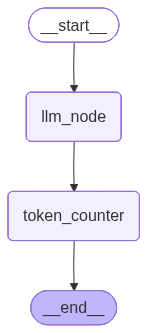

In [37]:
from IPython.display import Image, display

display(Image(app2.get_graph().draw_mermaid_png()))

In [38]:
result2 = app2.invoke({"input": "Explain diffference between langgraph and langchain."})

In [39]:
result2

{'input': 'Explain diffference between langgraph and langchain.',
 'output': 'LangGraph and LangChain are both frameworks that facilitate the development of applications involving natural language processing (NLP) and language models, but they serve different purposes and have distinct features.\n\n### LangChain:\n1. **Purpose**: LangChain is primarily designed to help developers build applications that utilize large language models (LLMs) by providing a structured way to create chains of operations that involve LLMs. It allows for the integration of LLMs with other components like APIs, databases, and more.\n\n2. **Features**:\n   - **Chain Construction**: It enables the creation of complex workflows by chaining together different components and functions.\n   - **Memory Management**: LangChain supports memory capabilities, allowing applications to maintain context over multiple interactions.\n   - **Integration**: It can integrate with various backends, including vector stores, APIs,

## Langgraph:
-- Introduction, concepts, etc
1. Tools
2. RAG
3. ReAct Agent
4. Multi Agent
5. Human in the loop


March 7th and 8th - RAG (concepts) , RAG (Langraph, Langchain, N8n)

March 14th and 15th - Langgraph React Agent, Multi-agent, Human in the loop

March 21 and 22 - Fine tuning

March 28 29 - Autogen

April 4 5 - Crew AI

## Example 3

1. we will use tools (Custom tools and Langchain integration tools)
2. See how langgraph intreact with LLM and tools

In [43]:
from langchain.tools import tool

@tool
def multiply(a:int , b:int) -> int:
    """
    Multiplies two numbers together.
    Args:
    a(int) : The first integer
    b(int) : The Second integer

    Returns:
        int : The product of a and b
        """
    return a * b

@tool
def add(a:int, b:int) -> int:
    """
    Add two numbers together.
    Args:
    a(int) : The first integer
    b(int) : The Second integer

    Returns:
        int : The sum of a and b
    """
    return a+b

@tool
def division(a:int, b:int) -> int:
    """
    Divide two numbers together.
    Args:
    a(int) : The first integer
    b(int) : The Second integer

    Returns:
        int : The division of a and b
    """
    if b==0:
        raise ValueError("Denominator can't be zero")
    else:
       return  a/b


In [44]:
!pip3 install -qU duckduckgo-search langchain-community


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [45]:
!pip3 install -U ddgs


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [46]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [69]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model="gpt-4o-mini",   # fast + cheap
    temperature=0.7
)
tools = [multiply,add,division,search]

llm_with_tools = model.bind_tools(tools)

tool_map = {"add":add,"multiply":multiply,"division":division,"search":search}


In [59]:
response = llm_with_tools.invoke("Hi")

In [60]:
response.content,response.tool_calls

('Hello! How can I assist you today?', [])

In [62]:
response = llm_with_tools.invoke("2+2")

In [63]:
response

AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 237, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_373a14eb6f', 'id': 'chatcmpl-DEdFdXk28XPnaPqtGr3ufWv7qxrS9', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019caa12-3090-7e12-a3c3-e50b9a12ec1d-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_0J1JiGUlmmvfNv3LtkQ91ivG', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 237, 'output_tokens': 17, 'total_tokens': 254, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [67]:
response.content

''

In [74]:
tool_call = response.tool_calls[0]
tool_call

{'name': 'add',
 'args': {'a': 2, 'b': 2},
 'id': 'call_0J1JiGUlmmvfNv3LtkQ91ivG',
 'type': 'tool_call'}

In [75]:
tool_map[tool_call['name']].invoke(tool_call['args'])

4

In [79]:
from langchain_core.messages import HumanMessage,ToolMessage

user_query = "2+2"

messages=[HumanMessage(content=user_query)]
response = llm_with_tools.invoke(messages)
messages.append(response)


In [80]:
messages

[HumanMessage(content='2+2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 237, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_373a14eb6f', 'id': 'chatcmpl-DEdPDmvcePBr6m6WYjvqneTk1yhAP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019caa1b-4147-7a82-806f-2045c66c5cce-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_o9kZtWtgJkDZlScOWXZoGVu1', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 237, 'output_tokens': 17, 'total_tokens': 254, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [84]:
for tool_call in response.tool_calls:
    tool_response = tool_map[tool_call['name']].invoke(tool_call['args'])
    print(tool_response)
    messages.append(ToolMessage(content=tool_response, tool_call_id=tool_call['id']))


4


In [85]:
messages

[HumanMessage(content='2+2', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 237, 'total_tokens': 254, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_373a14eb6f', 'id': 'chatcmpl-DEdPDmvcePBr6m6WYjvqneTk1yhAP', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--019caa1b-4147-7a82-806f-2045c66c5cce-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'call_o9kZtWtgJkDZlScOWXZoGVu1', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input_tokens': 237, 'output_tokens': 17, 'total_tokens': 254, 'input_token_details': {'audio': 0, 'cache_read': 0}, 

In [90]:
print(llm_with_tools.invoke(messages).content)

The result of \(2 + 2\) is \(4\).


In [ ]:
## Assigment --> Build this in langgraph


1. State(TypeDict)  message: List[]
2. Nodes, edges, start, finish, compile, invoke
3. for tools -> from langgraph.prebuilt import ToolNode, tools_condition

## Designing the state graph for tool calls

## https://www.langchain.com/langgraph

app.py -> AI logic 

requirement.txt -> package metioned with version number

Docker -> Image -> Container (azure functions, AWS lambda , GCP functions)